In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif, chi2, SelectKBest
from scipy.stats import kendalltau

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, roc_curve, ConfusionMatrixDisplay)
from sklearn import metrics
from matplotlib.colors import LinearSegmentedColormap
from sklearn.inspection import permutation_importance

from IPython.display import display
import warnings

# Pre-processing

## Remove text data and rate

In [2]:
def remove_data(df):
    """
    remove columns with text
    
    df: dataframe of articles
    """
    
    df.drop(['title', 'text', 'rate', 'clean_text'], axis=1, inplace = True)
    return df

In [3]:
def cat_to_num(df):
    """
    convert categorical value to numerical
    
    df: dataframe of articles
    """
    
    # order of the number does matter
    importance = {'Top': 1,
                  'High': 2,
                  'Mid': 3,
                  'Low': 4,
                  'Bottom': 5,
                  'Unknown': 6}
    classes = {'High': 1, 'Low': 0}

    df['2_classes'] = df['2_classes'].map(classes)
    df['importance'] = df['importance'].map(importance)
    return df

## Split Data

In [4]:
def split_data(df):
    """
    split data into 70%/30% for modelling
    
    df: dataframe of articles
    """

    X = df.iloc[:, 0:-1]
    y = df.iloc[:, -1] # last column is the 2_class which is the dependent variable

    # use stratify so train and test set have same distribution of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

# Feature Selection

In [5]:
def feature_selection(X_train, y_train, X_test):
    """
    select 10 features from numerical features
    
    X_train: independent variables from train set
    y_train: dependent variable from train set
    X_test: independent variables from test set
    """
    
    numerical_features= [feature for feature in list(X_train.columns) 
                         if feature != 'importance']

    # use ANOVA correlation coefficient to select top 10 features
    fs = SelectKBest(score_func=f_classif, k=10)
    X_train_fs = fs.fit_transform(X_train[numerical_features], y_train)
    X_test_fs = fs.transform(X_test[numerical_features])
    
    selected_features = [value for value, flag in zip(numerical_features, fs.get_support()) if flag]
    
    X_train_fs = pd.DataFrame(X_train_fs, columns=selected_features)
    X_test_fs = pd.DataFrame(X_test_fs, columns=selected_features)
    
    return X_train_fs, X_test_fs, fs

## Visualise ANOVA coefficient

In [6]:
def visualise_feature_selection(fs, numerical_features):
    """
    bar chart for the ANOVA correlation coefficient
    
    fs: object that select K best using certain score function
    numerical_features: all numerical feature name
    """
    
    p_values = fs.pvalues_
    significant = p_values < 0.05
    for i, (score, is_significant) in enumerate(zip(fs.scores_, significant)):
        print(f"{numerical_features[i]}: {score:.4f} - {'significant' if is_significant else 'not significant'}")

    bars = plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.xticks(range(len(numerical_features)), numerical_features, 
               rotation=45, ha='right', rotation_mode='anchor')

    # create text to show score
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2),
                 ha='center', va='bottom', fontsize=8)
    plt.show()
    
    selected_features = [value for value, flag in zip(numerical_features, fs.get_support()) if flag]
    print(selected_features)

# Modelling

In [7]:
def modelling(algorithm, X_train, X_test, y_train, y_test):
    """
    train classification model with cross validation (train/validation/test)
    
    algorithm: the model used for classification
    X_train: independent variables from train set
    X_test: independent variables from test set
    y_train: dependent variable from train set
    y_test: dependent variable from test set
    """
    
    # cross validation while maintaining the distribution of data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    cv_accuracies = []
    best_accuracy = 0
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    
        # create a pipeline to normalise value before building model
        pipe = Pipeline([("scaler", MinMaxScaler()),
                         ("model", algorithm)])
        pipe.fit(X_train_fold, y_train_fold)
    
        y_val_pred = pipe.predict(X_val_fold)
        accuracy = accuracy_score(y_val_fold, y_val_pred)
        
        cv_accuracies.append(accuracy)
        
        # capture the best model throughout the cross validation
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = pipe.steps[1][1]
            
    avg_cv_accuracy = sum(cv_accuracies) / 5
    print(f"Average Cross-Validation Accuracy: {avg_cv_accuracy:.2f}")
    print(f"Best Cross-Validation Accuracy: {best_accuracy:.2f}")
    
    # train the best model with the entire data
    pipe = Pipeline([("scaler", MinMaxScaler()),
                     ("model", best_model)])
    pipe.fit(X_train, y_train)
    
    y_test_pred = pipe.predict(X_test)
    y_test_proba = pipe.predict_proba(X_test)[:, 1]
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test Set Accuracy: {test_accuracy:.2f}")
    
    return best_model, y_test_pred, y_test_proba

In [8]:
def gridsearchcv_modelling(algorithm, X_train, X_test, y_train, y_test, param_grid):
    """
    train classification model with Grid Search Cross Validation to look for best parameters
    
    algorithm: the model used for classification
    X_train: independent variables from train set
    X_test: independent variables from test set
    y_train: dependent variable from train set
    y_test: dependent variable from test set
    param_grid: different values for parameters
    """ 
    
    # create a pipeline to normalise value before building model
    pipe = Pipeline([("scaler", MinMaxScaler()),
                     ("model", algorithm)])
    
    skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 1001)
    
    grid_search = GridSearchCV(pipe, param_grid, cv=skf.split(X_train,y_train), scoring='f1', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Classifier accuracy: {accuracy:.2f}")
    
    print(f"Best parameters: {grid_search.best_params_}")
    
    return best_model.named_steps['model'], y_pred, y_proba

# Feature Importance

In [9]:
def plot_importance(algo_name, model, X_test, y_test, feature_names):
    """
    bar chart for the importance of each features in the model
    
    algo_name: the name of the model used for classification
    model: the trained classification model
    X_test: independent variables from test set
    y_test: dependent variable from test set
    feature_names: name of all features used in classification
    """
    
    # Naive Bayes does not have built-in feature importance so need to use permutation importance
    if algo_name == "Naive Bayes":
        results = permutation_importance(model, X_test, y_test, scoring='f1', n_jobs = -1)
        importance = results.importances_mean
        print(importance)
    # Logistic Regression has coefficient to show how change in feature value impact the result
    elif algo_name in ["Logistic Regression"]:
        importance = model.coef_[0]
    # K-Nearest Neighbors and Support Vector Machine cannot calculate feature importance
    elif algo_name in ["K-Nearest Neighbors", "Support Vector Machine"]:
        return
    # Decision Tree and Random Forest has built-in feature importance
    else:
        try:
            importance = model.feature_importances_
        except AttributeError:
            warnings.warn(f"The model {algo_name} does not support feature importances.")
    
    plt.title(f"Feature Importance in {algo_name}")
    bars = plt.bar(range(len(importance)), importance)
    plt.xticks(range(len(importance)), feature_names, rotation=90)
    
    # create text to show feature importance score
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3),
                 ha='center', va='bottom', fontsize=8)
        
    plt.show()

# Measure Performance

## Performance Matrix

In [10]:
def performance_matrix(y_test, y_pred, y_proba):
    """
    calculate multiple performance matrix
    
    y_test: dependent variable from test set
    y_pred: predicted category of test set
    y_proba: predicted probability of test set
    """
    
    accuracy = round(accuracy_score(y_test, y_pred),2)
    precision = round(precision_score(y_test, y_pred),2) # propotion of positive predictions was actually correct
    recall = round(recall_score(y_test, y_pred),2) # proportion of actual positives was identified correctly
    f1 = round(f1_score(y_test, y_pred),2)
    auc = round(roc_auc_score(y_test, y_proba),2)
    
    metrics_df = pd.DataFrame({'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1 Score'],
                               'Value': [accuracy, precision, recall, auc, f1]})
    display(metrics_df)

## Confusion Matrix

In [11]:
def visualise_conf_max(y_test, y_pred, algo_name, balance = False, save = False):
    """
    draw confusion matrix
    
    y_test: dependent variable from test set
    y_pred: predicted category of test set
    algo_name: the name of the model used for classification
    balance: whether dataset is balance
    save: whether to save the plot
    """
    
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
    reversed_confusion_matrix = confusion_matrix[::-1, ::-1]
    colors = ["#C35F4A", "#EEF6F0", "#FFB03A"]
    custom_cmap = LinearSegmentedColormap.from_list("custom_red_blue", colors)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = reversed_confusion_matrix, 
                                                display_labels=['High', 'Low'])

    ax = cm_display.plot(cmap=custom_cmap, colorbar=False)
    if balance:
        title = "Balance Class"
    else:
        title = "Imbalance Class"
    ax.ax_.set_title(f'Confusion Matrix for {title}', fontdict={"fontsize":20})

    # adjust display of the text
    for text in ax.ax_.texts:
        text.set_fontsize(20)
        text.set_color('black') 
        text.set_fontweight('bold')

    # add gridline for confusion matrix
    ax.ax_.axhline(y=0.5, color='black', linewidth=1)
    ax.ax_.axvline(x=0.5, color='black', linewidth=1)
    
    ax.ax_.set_xlabel('Predicted label', fontsize=20)
    ax.ax_.set_ylabel('True label', fontsize=20)

    ax.ax_.tick_params(axis='both', which='major', labelsize=18)

    # save image
    if save and balance:
        image_name = "Confusion Matrix (Balance)"
        plt.savefig(f"Poster/{algo_name}_{image_name}", dpi=1000, bbox_inches='tight', transparent=True)
    elif save and not balance:
        image_name = "Confusion Matrix (Imbalance)"
        plt.savefig(f"Poster/{algo_name}_{image_name}", dpi=1000, bbox_inches='tight', transparent=True)
    plt.show()

## ROC Curve

In [12]:
def visualise_roc_curve(result_proba):
    """
    ROC curve for all model
    
    result_proba: dictionary of model name and predicted probability
    """
    
    for name, y_proba in result_proba.items():
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {auc:.2f})')

    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Classifiers')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
def prepare_data(df):
    """
    Prepare the data before building classification model
    
    df: dataframe of articles
    """
    
    df = remove_data(df)
    df = cat_to_num(df)
    X_train, X_test, y_train, y_test = split_data(df)
    
    return df, X_train, X_test, y_train, y_test

In [14]:
algorithms = {"Naive Bayes": GaussianNB(),
              "Logistic Regression": LogisticRegression(), 
              "K-Nearest Neighbors": KNeighborsClassifier(), 
              "Support Vector Machine": SVC(probability=True), 
              "Decision Tree": DecisionTreeClassifier(), 
              "Random Forest": RandomForestClassifier()}

def prediction_analysis(df, X_train, X_test, y_train, y_test, algo_name, param_grid = None, balance = False, cv = False):
    """
    build classification model and visualise result
    
    df: dataframe of articles
    X_train: independent variables from train set
    X_test: independent variables from test set
    y_train: dependent variable from train set
    y_test: dependent variable from test set
    algo_name: the name of the model used for classification
    param_grid: different values for parameters
    balance: whether dataset is balance
    cv: whether to perform Grid Search Cross Validation
    """
    
    feature_names = X_train.columns
    X_train, X_test, y_train, y_test = X_train.values, X_test.values, y_train.values, y_test.values
    
    if cv and param_grid:
        model, y_pred, y_proba = gridsearchcv_modelling(algorithms[algo_name],
                                                        X_train, X_test, y_train, y_test,
                                                        param_grid)
    else:
        model, y_pred, y_proba = modelling(algorithms[algo_name], 
                                           X_train, X_test, y_train, y_test)
    
    performance_matrix(y_test, y_pred, y_proba)
    
    visualise_conf_max(y_test, y_pred, algo_name, balance)
    
    plot_importance(algo_name, model, X_test, y_test, feature_names)
    
    return y_proba

# Imbalance Data

In [15]:
df = pd.read_csv(f'../Data/grouped_dataset_(Imbalance).csv', keep_default_na=False)

In [16]:
df, X_train, X_test, y_train, y_test = prepare_data(df)

## Feature selection

In [17]:
# X_train_fs, X_test_fs, fs = feature_selection(X_train, y_train, X_test)

# numerical_features = [feature for feature in list(X_train.columns) if feature != 'importance']

# # concatenate categorical feature back to selected numerical features
# X_train = pd.concat([X_train_fs, X_train['importance'].reset_index(drop=True)], axis=1)
# X_test = pd.concat([X_test_fs, X_test['importance'].reset_index(drop=True)], axis=1)

# visualise_feature_selection(fs, numerical_features)

## Naive Bayes

Average Cross-Validation Accuracy: 0.81
Best Cross-Validation Accuracy: 0.82
Test Set Accuracy: 0.80


,Metric,Value
0,Accuracy,0.80
1,Precision,0.19
2,Recall,0.57
3,AUC,0.80
4,F1 Score,0.28


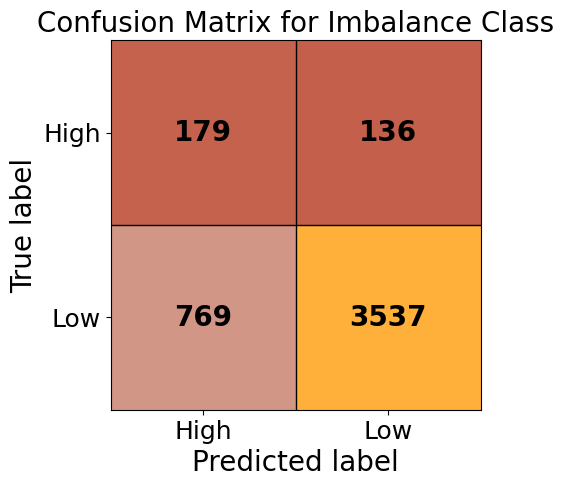

[ 0.00000000e+00  2.00019311e-02  2.67736826e-02  3.25689152e-02
  2.34205702e-04  1.99565620e-03 -1.07256833e-03  4.83354077e-04
 -1.28308454e-05 -1.28308454e-05 -1.89157100e-03  2.44648291e-02
  1.05459293e-03  1.04267838e-04  3.83510508e-05  6.21549539e-04
  6.13274804e-04  3.53268317e-02  1.92121582e-04 -2.56616907e-05
  1.17158733e-04]


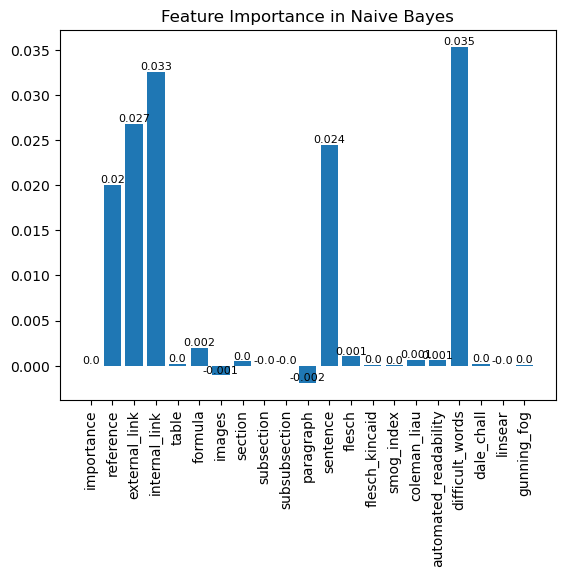

In [18]:
nb_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Naive Bayes")

## Logistic Regression

Average Cross-Validation Accuracy: 0.93
Best Cross-Validation Accuracy: 0.93
Test Set Accuracy: 0.93


,Metric,Value
0,Accuracy,0.93
1,Precision,0.39
2,Recall,0.06
3,AUC,0.86
4,F1 Score,0.10


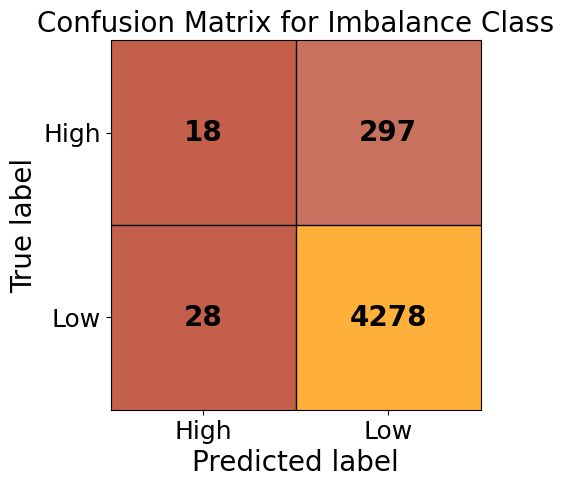

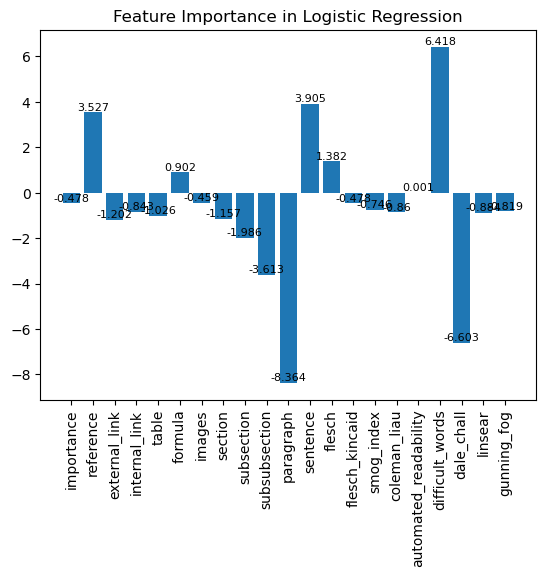

In [19]:
lr_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Logistic Regression")

## K-Nearest Neighbors

Average Cross-Validation Accuracy: 0.93
Best Cross-Validation Accuracy: 0.94
Test Set Accuracy: 0.93


,Metric,Value
0,Accuracy,0.93
1,Precision,0.54
2,Recall,0.18
3,AUC,0.77
4,F1 Score,0.27


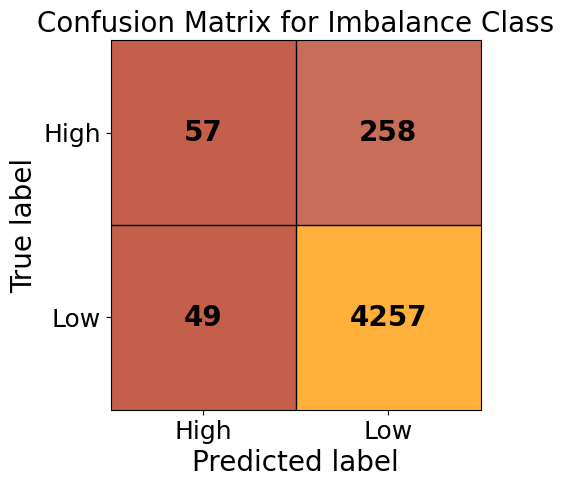

In [20]:
knn_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "K-Nearest Neighbors")

## Support Vector Machine

Average Cross-Validation Accuracy: 0.93
Best Cross-Validation Accuracy: 0.93
Test Set Accuracy: 0.93


C:\Users\khais\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Metric,Value
0,Accuracy,0.93
1,Precision,0.00
2,Recall,0.00
3,AUC,0.82
4,F1 Score,0.00


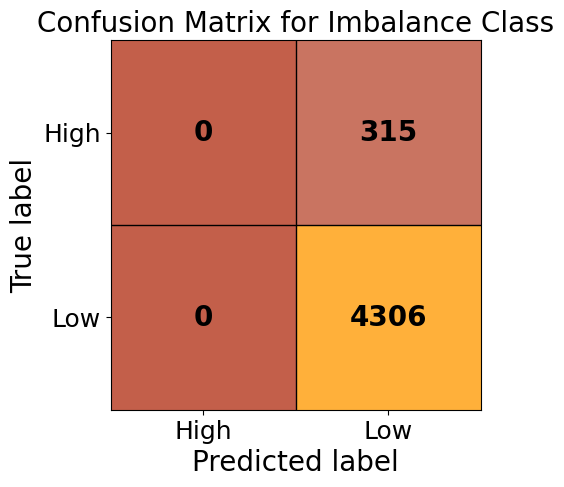

In [21]:
svm_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Support Vector Machine")

## Decision Tree

Average Cross-Validation Accuracy: 0.90
Best Cross-Validation Accuracy: 0.91
Test Set Accuracy: 0.90


,Metric,Value
0,Accuracy,0.90
1,Precision,0.32
2,Recall,0.36
3,AUC,0.65
4,F1 Score,0.33


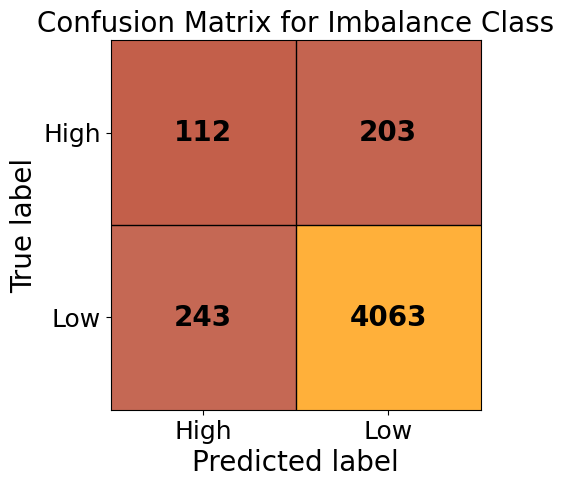

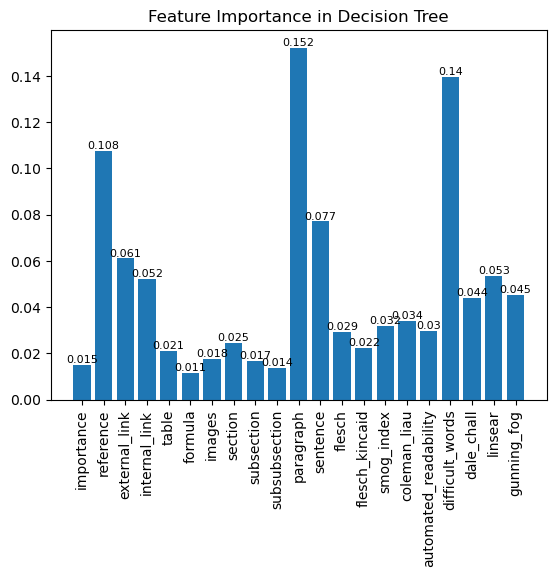

In [22]:
dt_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Decision Tree")

## Random Forest

Average Cross-Validation Accuracy: 0.94
Best Cross-Validation Accuracy: 0.94
Test Set Accuracy: 0.94


,Metric,Value
0,Accuracy,0.94
1,Precision,0.65
2,Recall,0.10
3,AUC,0.90
4,F1 Score,0.18


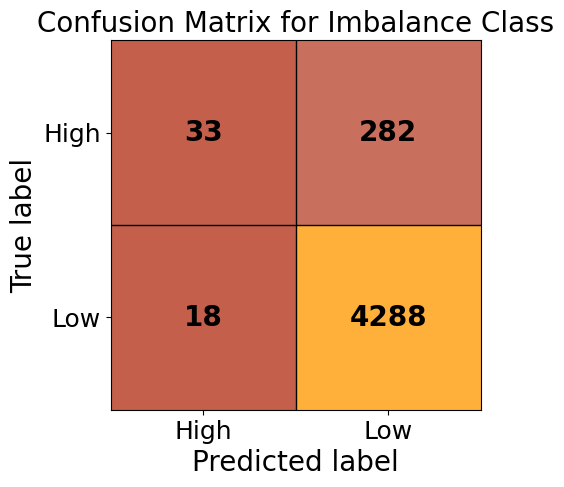

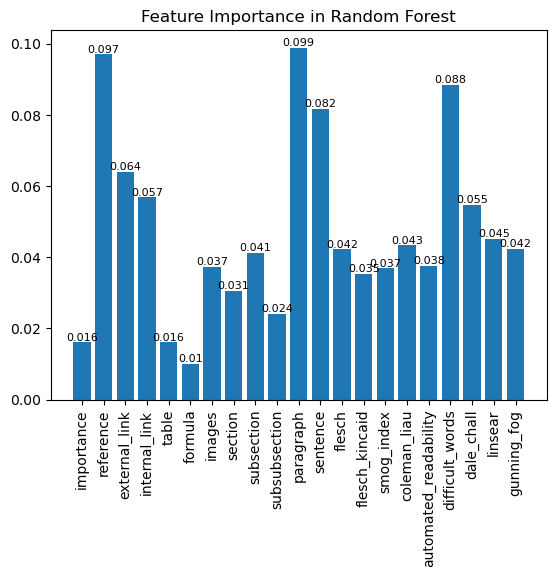

In [23]:
rf_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Random Forest")

## ROC Curve

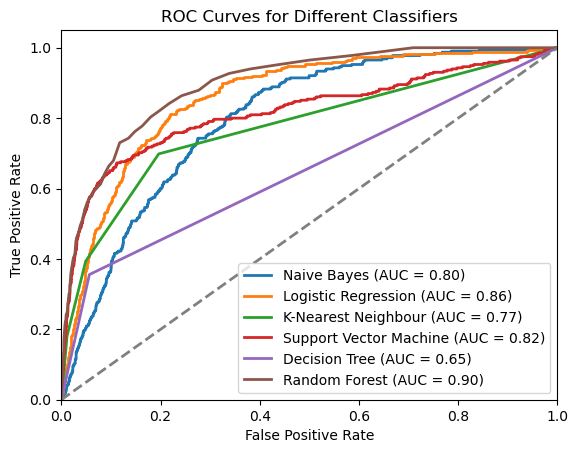

In [24]:
result_proba = {"Naive Bayes": nb_y_proba,
                "Logistic Regression": lr_y_proba, 
                "K-Nearest Neighbour": knn_y_proba, 
                "Support Vector Machine": svm_y_proba, 
                "Decision Tree": dt_y_proba, 
                "Random Forest": rf_y_proba}

visualise_roc_curve(result_proba)

# Balance Data

In [25]:
df = pd.read_csv(f'../Data/grouped_dataset_(Balance).csv', keep_default_na=False)

In [26]:
df, X_train, X_test, y_train, y_test = prepare_data(df)

## Feature Selection

In [27]:
# X_train_fs, X_test_fs, fs = feature_selection(X_train, y_train, X_test)

# numerical_features = [feature for feature in list(X_train.columns) if feature != 'importance']

# # concatenate categorical feature back to selected numerical features
# X_train = pd.concat([X_train_fs, X_train['importance'].reset_index(drop=True)], axis=1)
# X_test = pd.concat([X_test_fs, X_test['importance'].reset_index(drop=True)], axis=1)

# visualise_feature_selection(fs, numerical_features)

## Naive Bayes

Average Cross-Validation Accuracy: 0.83
Best Cross-Validation Accuracy: 0.83
Test Set Accuracy: 0.82


,Metric,Value
0,Accuracy,0.82
1,Precision,0.76
2,Recall,0.93
3,AUC,0.92
4,F1 Score,0.84


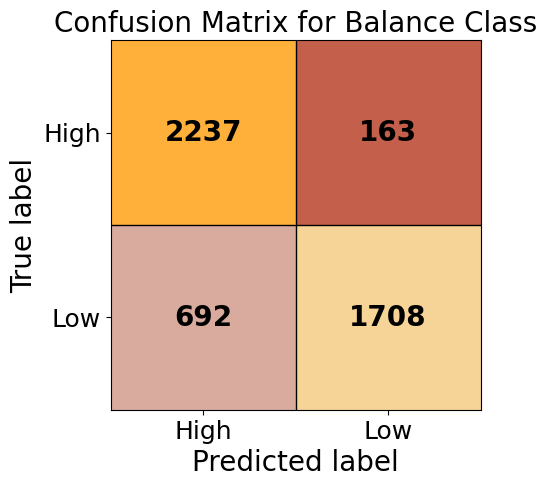

[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.76969373e-07 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.66250693e-04
 1.38484687e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]


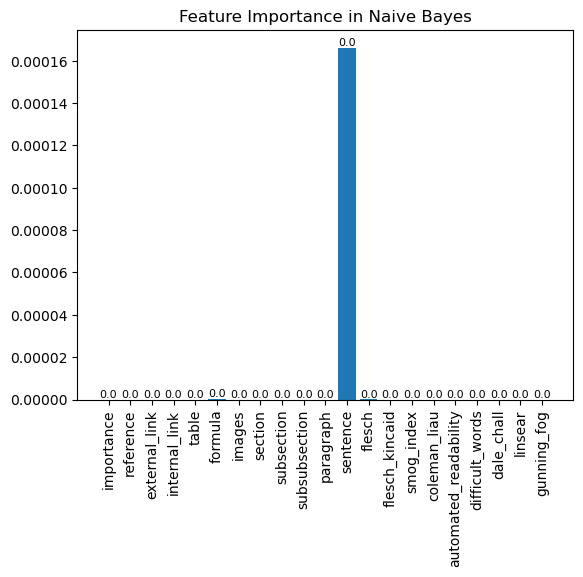

In [28]:
nb_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Naive Bayes", balance = True)

## Logistic Regression

Average Cross-Validation Accuracy: 0.87
Best Cross-Validation Accuracy: 0.88
Test Set Accuracy: 0.86


,Metric,Value
0,Accuracy,0.86
1,Precision,0.83
2,Recall,0.92
3,AUC,0.94
4,F1 Score,0.87


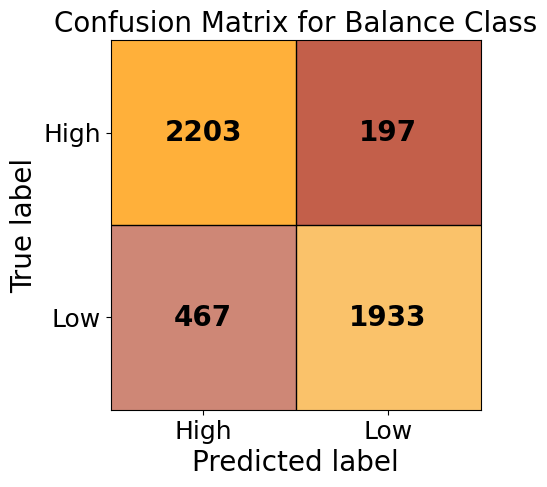

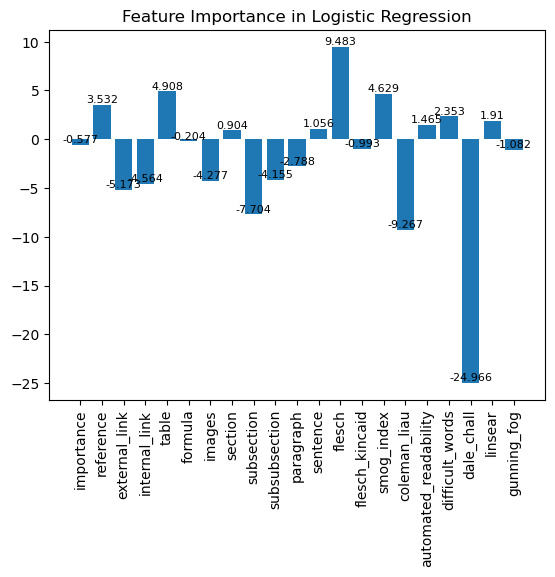

In [29]:
lr_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Logistic Regression", balance = True)

## K-Nearest Neighbors

Classifier accuracy: 0.95
Best parameters: {'model__n_neighbors': 10, 'model__p': 1, 'model__weights': 'distance'}


,Metric,Value
0,Accuracy,0.95
1,Precision,0.97
2,Recall,0.93
3,AUC,0.99
4,F1 Score,0.95


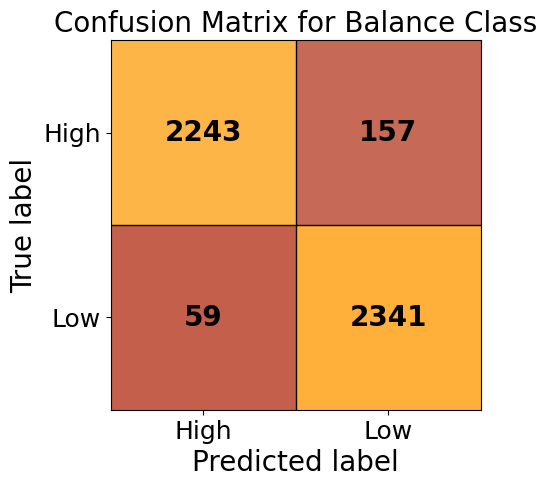

In [30]:
# param_grid = {'model__n_neighbors': [i for i in range(1, 20)], # number of neighbors
#               'model__weights': ['uniform', 'distance'], # weight function used in prediction
#               'model__p': [1, 2] # p for Minkowski metric
#              }

param_grid = {'model__n_neighbors': [10], # number of neighbors
              'model__weights': ['distance'], # weight function used in prediction
              'model__p': [1] # p for Minkowski metric
             }

knn_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "K-Nearest Neighbors",
                                  param_grid, balance = True, cv = True)

## Support Vector Machine

Average Cross-Validation Accuracy: 0.93
Best Cross-Validation Accuracy: 0.94
Test Set Accuracy: 0.93


,Metric,Value
0,Accuracy,0.93
1,Precision,0.92
2,Recall,0.93
3,AUC,0.98
4,F1 Score,0.93


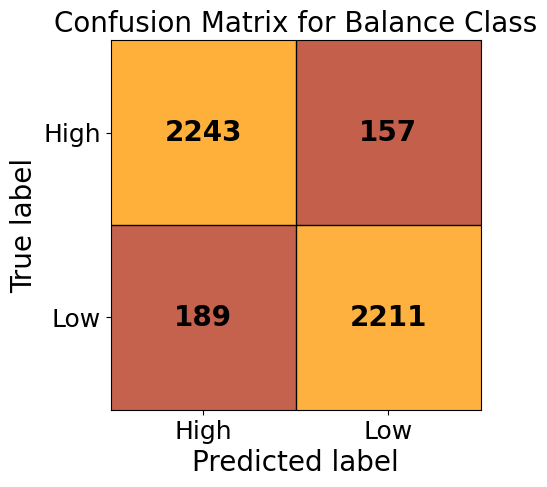

In [31]:
svm_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Support Vector Machine", balance = True)

## Decision Tree

Classifier accuracy: 0.91
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_split': 2, 'model__splitter': 'best'}


,Metric,Value
0,Accuracy,0.91
1,Precision,0.91
2,Recall,0.91
3,AUC,0.95
4,F1 Score,0.91


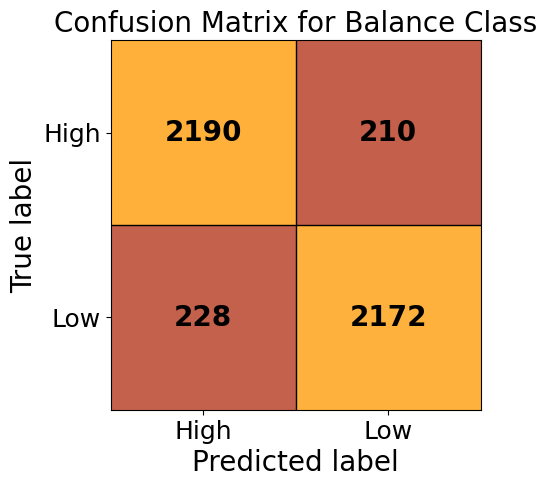

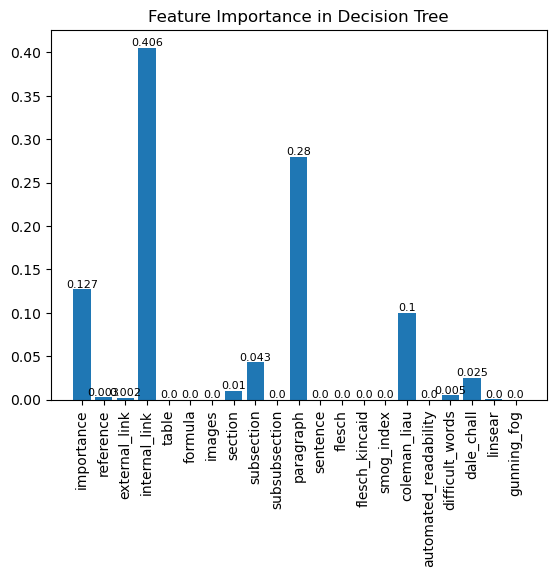

In [32]:
# param_grid = {'model__criterion': ['gini', 'entropy'], 
#               'model__splitter': ['random', 'best'],
#               'model__max_depth': [i for i in range(10, 30, 2)] + [None], 
#               'model__min_samples_split': [i for i in range(2, 50, 5)],
#               'model__max_features': [20, 10, 'sqrt', 'log2', None],
#              }

param_grid = {'model__criterion': ['entropy'], 
              'model__splitter': ['best'],
              'model__max_depth': [5],
              'model__min_samples_split': [2],
              'model__max_features': [None],
             }

dt_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Decision Tree",
                                 param_grid, balance = True, cv = True)

## Random Forest

Classifier accuracy: 0.97
Best parameters: {'model__criterion': 'gini', 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 150}


,Metric,Value
0,Accuracy,0.97
1,Precision,0.98
2,Recall,0.96
3,AUC,0.99
4,F1 Score,0.97


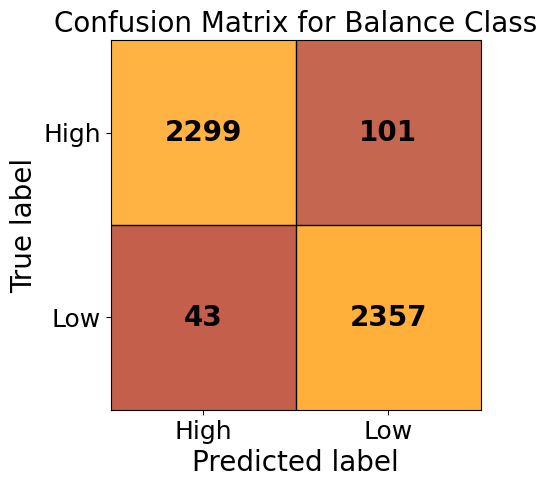

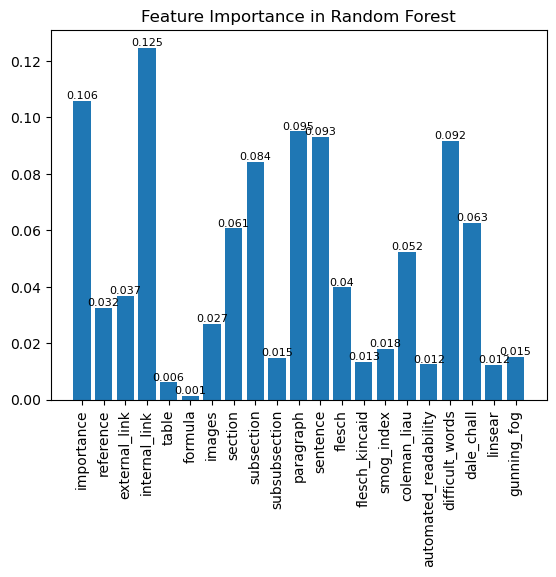

In [33]:
# param_grid = {'model__n_estimators': [i for i in range(100, 200, 50)],
#               'model__criterion': ['gini', 'entropy'],
#               'model__max_depth': [i for i in range(10, 20, 2)] + [None], 
#               'model__min_samples_split': [i for i in range(2, 20, 5)],
#               'model__max_features': [20, 10, 0.3, 'sqrt', 'log2', None],
#              }

param_grid = {'model__n_estimators': [150],
              'model__criterion': ['gini'],
              'model__max_depth': [None], 
              'model__min_samples_split': [2],
              'model__max_features': ['sqrt'],
             }

rf_y_proba = prediction_analysis(df, X_train, X_test, y_train, y_test, "Random Forest",
                                 param_grid, balance = True, cv = True)

## ROC Curve

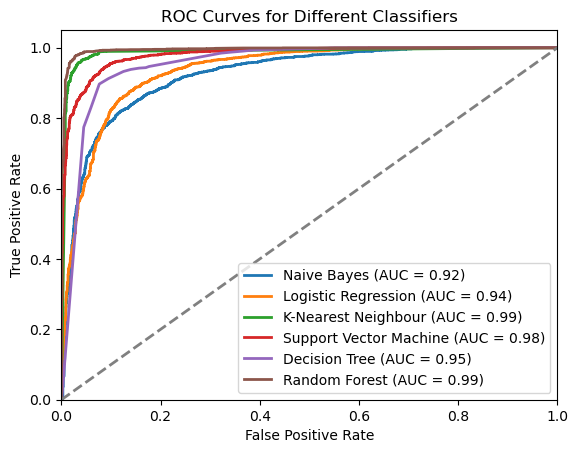

In [34]:
result_proba = {"Naive Bayes": nb_y_proba,
                "Logistic Regression": lr_y_proba, 
                "K-Nearest Neighbour": knn_y_proba, 
                "Support Vector Machine": svm_y_proba, 
                "Decision Tree": dt_y_proba, 
                "Random Forest": rf_y_proba}

visualise_roc_curve(result_proba)